<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 5386, '日付': '2021-08-18T08:00:00.000Z'},
 {'小計': 5534, '日付': '2021-08-19T08:00:00.000Z'},
 {'小計': 5405, '日付': '2021-08-20T08:00:00.000Z'},
 {'小計': 5074, '日付': '2021-08-21T08:00:00.000Z'},
 {'小計': 4392, '日付': '2021-08-22T08:00:00.000Z'},
 {'小計': 2447, '日付': '2021-08-23T08:00:00.000Z'},
 {'小計': 4220, '日付': '2021-08-24T08:00:00.000Z'},
 {'小計': 4228, '日付': '2021-08-25T08:00:00.000Z'},
 {'小計': 4704, '日付': '2021-08-26T08:00:00.000Z'},
 {'小計': 4227, '日付': '2021-08-27T08:00:00.000Z'},
 {'小計': 3581, '日付': '2021-08-28T08:00:00.000Z'},
 {'小計': 3081, '日付': '2021-08-29T08:00:00.000Z'},
 {'小計': 1915, '日付': '2021-08-30T08:00:00.000Z'},
 {'小計': 2909, '日付': '2021-08-31T08:00:00.000Z'},
 {'小計': 3168, '日付': '2021-09-01T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-08-28 17:00:00+09:00,1340,0,3581,2021-08-28 17:00:00+09:00
2021-08-29 17:00:00+09:00,987,0,3081,2021-08-29 17:00:00+09:00
2021-08-30 17:00:00+09:00,1229,0,1915,2021-08-30 17:00:00+09:00
2021-08-31 17:00:00+09:00,994,0,2909,2021-08-31 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-08-28 17:00:00+09:00,1340,0,3581,2021-08-28 17:00:00+09:00,1412.142857,9885.0,0.0,0.0,3971.285714,27799.0
2021-08-29 17:00:00+09:00,987,0,3081,2021-08-29 17:00:00+09:00,1334.714286,9343.0,0.0,0.0,3784.000000,26488.0
2021-08-30 17:00:00+09:00,1229,0,1915,2021-08-30 17:00:00+09:00,1265.285714,8857.0,0.0,0.0,3708.000000,25956.0
2021-08-31 17:00:00+09:00,994,0,2909,2021-08-31 17:00:00+09:00,1214.857143,8504.0,0.0,0.0,3520.714286,24645.0
2021-09-01 17:00:00+09:00,0,0,3168,2021-09-01 17:00:00+09:00,1019.857143,7139.0,0.0,0.0,3369.285714,23585.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-08-18 17:00:00+09:00,1682,0,5386,2021-08-18 17:00:00+09:00,1798.000000,12586.0,0.0,0.0,4696.571429,32876.0,'21w33,Wed
2021-08-19 17:00:00+09:00,1610,0,5534,2021-08-19 17:00:00+09:00,1761.571429,12331.0,0.0,0.0,4774.428571,33421.0,'21w33,Thu
2021-08-20 17:00:00+09:00,1710,0,5405,2021-08-20 17:00:00+09:00,1756.285714,12294.0,0.0,0.0,4721.857143,33053.0,'21w33,Fri
2021-08-21 17:00:00+09:00,1814,0,5074,2021-08-21 17:00:00+09:00,1721.000000,12047.0,0.0,0.0,4719.000000,33033.0,'21w33,Sat
2021-08-22 17:00:00+09:00,1529,0,4392,2021-08-22 17:00:00+09:00,1694.285714,11860.0,0.0,0.0,4732.857143,33130.0,'21w33,Sun
2021-08-23 17:00:00+09:00,1715,0,2447,2021-08-23 17:00:00+09:00,1690.714286,11835.0,0.0,0.0,4659.285714,32615.0,'21w34,Mon
2021-08-24 17:00:00+09:00,1347,0,4220,2021-08-24 17:00:00+09:00,1629.571429,11407.0,0.0,0.0,4636.857143,32458.0,'21w34,Tue
2021-08-25 17:00:00+09:00,1365,0,4228,2021-08-25 17:00:00+09:00,1584.285714,11090.0,0.0,0.0,4471.428571,31300.0,'21w34,Wed
2021-08-26 17:00:00+09:00,1370,0,4704,2021-08-26 17:00:00+09:00,1550.000000,10850.0,0.0,0.0,4352.857143,30470.0,'21w34,Thu
2021-08-27 17:00:00+09:00,1219,0,4227,2021-08-27 17:00:00+09:00,1479.857143,10359.0,0.0,0.0,4184.571429,29292.0,'21w34,Fri


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-08-15 17:00:00+09:00,4263.857143,29847
2021-08-22 17:00:00+09:00,4732.857143,33130
2021-08-29 17:00:00+09:00,3784.000000,26488
2021-09-01 17:00:00+09:00,2664.000000,7992
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-08-18 17:00:00+09:00,1682,0,5386,2021-08-18 17:00:00+09:00,1798.000000,12586.0,0.0,0.0,4696.571429,32876.0,'21w33,Wed,NaN,NaN
2021-08-19 17:00:00+09:00,1610,0,5534,2021-08-19 17:00:00+09:00,1761.571429,12331.0,0.0,0.0,4774.428571,33421.0,'21w33,Thu,NaN,NaN
2021-08-20 17:00:00+09:00,1710,0,5405,2021-08-20 17:00:00+09:00,1756.285714,12294.0,0.0,0.0,4721.857143,33053.0,'21w33,Fri,NaN,NaN
2021-08-21 17:00:00+09:00,1814,0,5074,2021-08-21 17:00:00+09:00,1721.000000,12047.0,0.0,0.0,4719.000000,33033.0,'21w33,Sat,NaN,NaN
2021-08-22 17:00:00+09:00,1529,0,4392,2021-08-22 17:00:00+09:00,1694.285714,11860.0,0.0,0.0,4732.857143,33130.0,'21w33,Sun,4732.857143,33130.0
2021-08-23 17:00:00+09:00,1715,0,2447,2021-08-23 17:00:00+09:00,1690.714286,11835.0,0.0,0.0,4659.285714,32615.0,'21w34,Mon,NaN,NaN
2021-08-24 17:00:00+09:00,1347,0,4220,2021-08-24 17:00:00+09:00,1629.571429,11407.0,0.0,0.0,4636.857143,32458.0,'21w34,Tue,NaN,NaN
2021-08-25 17:00:00+09:00,1365,0,4228,2021-08-25 17:00:00+09:00,1584.285714,11090.0,0.0,0.0,4471.428571,31300.0,'21w34,Wed,NaN,NaN
2021-08-26 17:00:00+09:00,1370,0,4704,2021-08-26 17:00:00+09:00,1550.000000,10850.0,0.0,0.0,4352.857143,30470.0,'21w34,Thu,NaN,NaN
2021-08-27 17:00:00+09:00,1219,0,4227,2021-08-27 17:00:00+09:00,1479.857143,10359.0,0.0,0.0,4184.571429,29292.0,'21w34,Fri,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

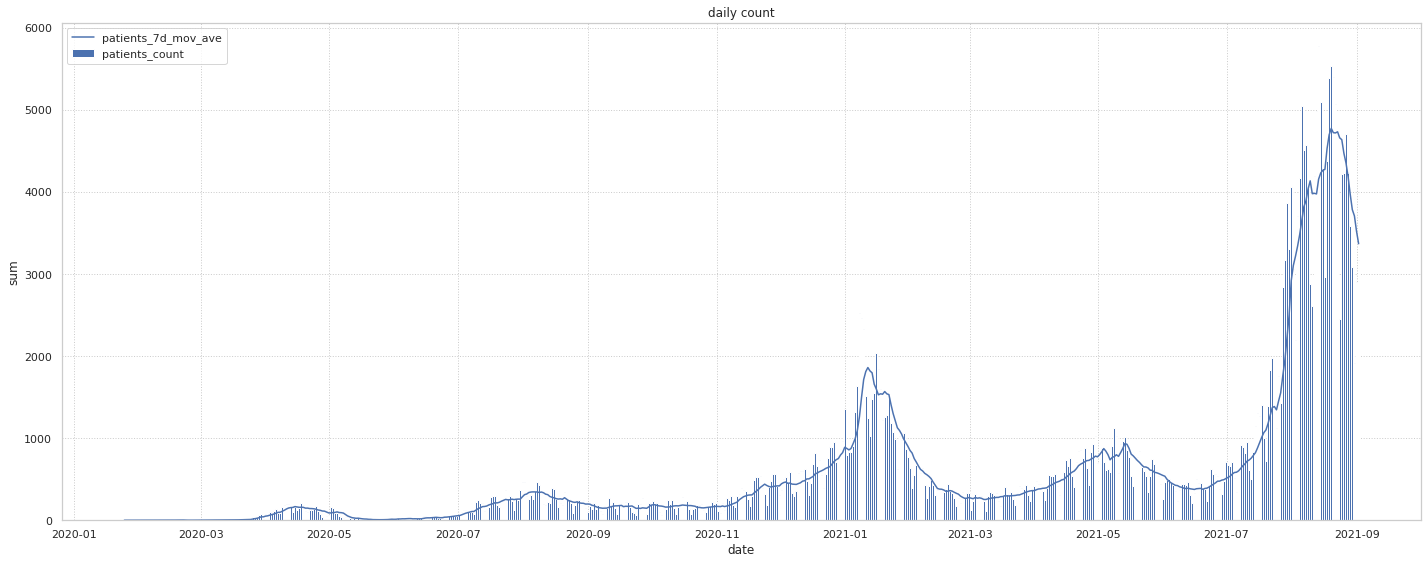

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
572,1.629274e+09,2021,8,18,0,0,0,0,0,0,1,572,0,498,1682,1798.000000,12586.0,0,0.0,0.0,5386,4696.571429,32876.0
573,1.629360e+09,2021,8,19,0,0,0,0,1,0,0,573,0,499,1610,1761.571429,12331.0,0,0.0,0.0,5534,4774.428571,33421.0
574,1.629446e+09,2021,8,20,1,0,0,0,0,0,0,574,0,500,1710,1756.285714,12294.0,0,0.0,0.0,5405,4721.857143,33053.0
575,1.629533e+09,2021,8,21,0,0,1,0,0,0,0,575,0,501,1814,1721.000000,12047.0,0,0.0,0.0,5074,4719.000000,33033.0
576,1.629619e+09,2021,8,22,0,0,0,1,0,0,0,576,0,502,1529,1694.285714,11860.0,0,0.0,0.0,4392,4732.857143,33130.0
577,1.629706e+09,2021,8,23,0,1,0,0,0,0,0,577,0,503,1715,1690.714286,11835.0,0,0.0,0.0,2447,4659.285714,32615.0
578,1.629792e+09,2021,8,24,0,0,0,0,0,1,0,578,0,504,1347,1629.571429,11407.0,0,0.0,0.0,4220,4636.857143,32458.0
579,1.629878e+09,2021,8,25,0,0,0,0,0,0,1,579,0,505,1365,1584.285714,11090.0,0,0.0,0.0,4228,4471.428571,31300.0
580,1.629965e+09,2021,8,26,0,0,0,0,1,0,0,580,0,506,1370,1550.000000,10850.0,0,0.0,0.0,4704,4352.857143,30470.0
581,1.630051e+09,2021,8,27,1,0,0,0,0,0,0,581,0,507,1219,1479.857143,10359.0,0,0.0,0.0,4227,4184.571429,29292.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            587 non-null    float64
 1   year                 587 non-null    int64  
 2   month                587 non-null    int64  
 3   day                  587 non-null    int64  
 4   Fri                  587 non-null    uint8  
 5   Mon                  587 non-null    uint8  
 6   Sat                  587 non-null    uint8  
 7   Sun                  587 non-null    uint8  
 8   Thu                  587 non-null    uint8  
 9   Tue                  587 non-null    uint8  
 10  Wed                  587 non-null    uint8  
 11  passed               587 non-null    int64  
 12  emergency            587 non-null    int64  
 13  em_passed            587 non-null    int64  
 14  contacts_count       587 non-null    int64  
 15  contacts_7d_mov_ave  587 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,5.870000e+02,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.00000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000
mean,1.605168e+09,2020.415673,5.911414,15.856899,0.143101,0.143101,0.143101,0.143101,0.141397,0.143101,0.143101,293.00000,0.083475,223.727428,705.289608,701.215097,4908.499148,627.800681,627.800681,4394.604770,590.701874,575.654734,4029.555366
std,1.465314e+07,0.493258,3.117000,8.866855,0.350474,0.350474,0.350474,0.350474,0.348728,0.350474,0.350474,169.59658,0.276835,162.576967,469.386112,456.848923,3197.952448,844.807169,766.375619,5364.629335,983.730211,936.119331,6552.852404
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.592510e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,146.50000,0.000000,72.500000,385.000000,387.785714,2714.500000,0.000000,0.000000,0.000000,96.000000,111.357143,779.500000
50%,1.605168e+09,2020.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,293.00000,0.000000,219.000000,545.000000,557.714286,3904.000000,0.000000,0.000000,0.000000,275.000000,277.857143,1945.000000
75%,1.617826e+09,2021.000000,8.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,439.50000,0.000000,365.500000,852.500000,856.857143,5998.000000,1276.000000,1243.857143,8707.000000,587.500000,586.000000,4102.000000
max,1.630483e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,586.00000,1.000000,512.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,5773.000000,4774.428571,33421.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.853621,0.165612,0.020636,-0.006029,0.001206,-0.003617,-0.001206,-3.887722e-18,0.003617,0.006029,1.000000e+00,-0.347292,0.997034,-0.056717,-0.046480,-0.046477,-0.587299,-0.632888,-0.632888,0.601260,0.614940,0.614945
year,8.536211e-01,1.000000,-0.370031,-0.020322,0.000824,0.000824,0.000824,0.000824,-4.968795e-03,0.000824,0.000824,8.536211e-01,-0.254539,0.865932,-0.111484,-0.097719,-0.097717,-0.627310,-0.691510,-0.691510,0.500442,0.517498,0.517500
month,1.656118e-01,-0.370031,1.000000,-0.017810,-0.013370,0.000689,-0.008683,-0.003997,9.973174e-03,0.005376,0.010062,1.656118e-01,-0.135782,0.136750,0.111322,0.103283,0.103286,0.142057,0.183733,0.183733,0.121307,0.112695,0.112701
day,2.063616e-02,-0.020322,-0.017810,1.000000,0.010994,-0.000538,0.006601,0.002757,-5.586513e-03,-0.004931,-0.009324,2.063616e-02,-0.005553,0.022170,0.000604,0.001317,0.001314,-0.001998,-0.015784,-0.015784,0.037017,0.042764,0.042759
Fri,-6.029049e-03,0.000824,-0.013370,0.010994,1.000000,-0.166998,-0.166998,-0.166998,-1.658362e-01,-0.166998,-0.166998,-6.029049e-03,-0.000210,-0.005334,-0.017244,-0.004354,-0.004353,0.030931,-0.000570,-0.000570,0.028446,-0.004749,-0.004752
Mon,1.205810e-03,0.000824,0.000689,-0.000538,-0.166998,1.000000,-0.166998,-0.166998,-1.658362e-01,-0.166998,-0.166998,1.205810e-03,-0.000210,0.001225,0.037880,0.001061,0.001061,0.123828,-0.000570,-0.000570,-0.091211,0.001621,0.001622
Sat,-3.617429e-03,0.000824,-0.008683,0.006601,-0.166998,-0.166998,1.000000,-0.166998,-1.658362e-01,-0.166998,-0.166998,-3.617429e-03,-0.000210,-0.003148,0.050089,-0.002314,-0.002313,-0.144050,-0.000570,-0.000570,0.029049,-0.002089,-0.002091
Sun,-1.205810e-03,0.000824,-0.003997,0.002757,-0.166998,-0.166998,-0.166998,1.000000,-1.658362e-01,-0.166998,-0.166998,-1.205810e-03,-0.000210,-0.000961,-0.022347,-0.000811,-0.000810,-0.132759,-0.000570,-0.000570,-0.022912,0.000199,0.000199
Thu,-3.887722e-18,-0.004969,0.009973,-0.005587,-0.165836,-0.165836,-0.165836,-0.165836,1.000000e+00,-0.165836,-0.165836,-3.895316e-18,0.001265,-0.000824,-0.004587,0.001270,0.001271,0.039577,0.003436,0.003436,0.049320,-0.004924,-0.004923
Tue,3.617429e-03,0.000824,0.005376,-0.004931,-0.166998,-0.166998,-0.166998,-0.166998,-1.658362e-01,1.000000,-0.166998,3.617429e-03,-0.000210,0.003411,-0.022659,0.002574,0.002575,0.049092,-0.000570,-0.000570,-0.017254,0.003782,0.003783


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,1.630138e+09,0,0,1,0,0,0,0,582,0,508,1340,0,3581,3971.285714,27799.0
583,1.630224e+09,0,0,0,1,0,0,0,583,0,509,987,0,3081,3784.000000,26488.0
584,1.630310e+09,0,1,0,0,0,0,0,584,0,510,1229,0,1915,3708.000000,25956.0
585,1.630397e+09,0,0,0,0,0,1,0,585,0,511,994,0,2909,3520.714286,24645.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
582,1.630138e+09,582,0,3581,3971.285714,27799.0
583,1.630224e+09,583,0,3081,3784.000000,26488.0
584,1.630310e+09,584,0,1915,3708.000000,25956.0
585,1.630397e+09,585,0,2909,3520.714286,24645.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

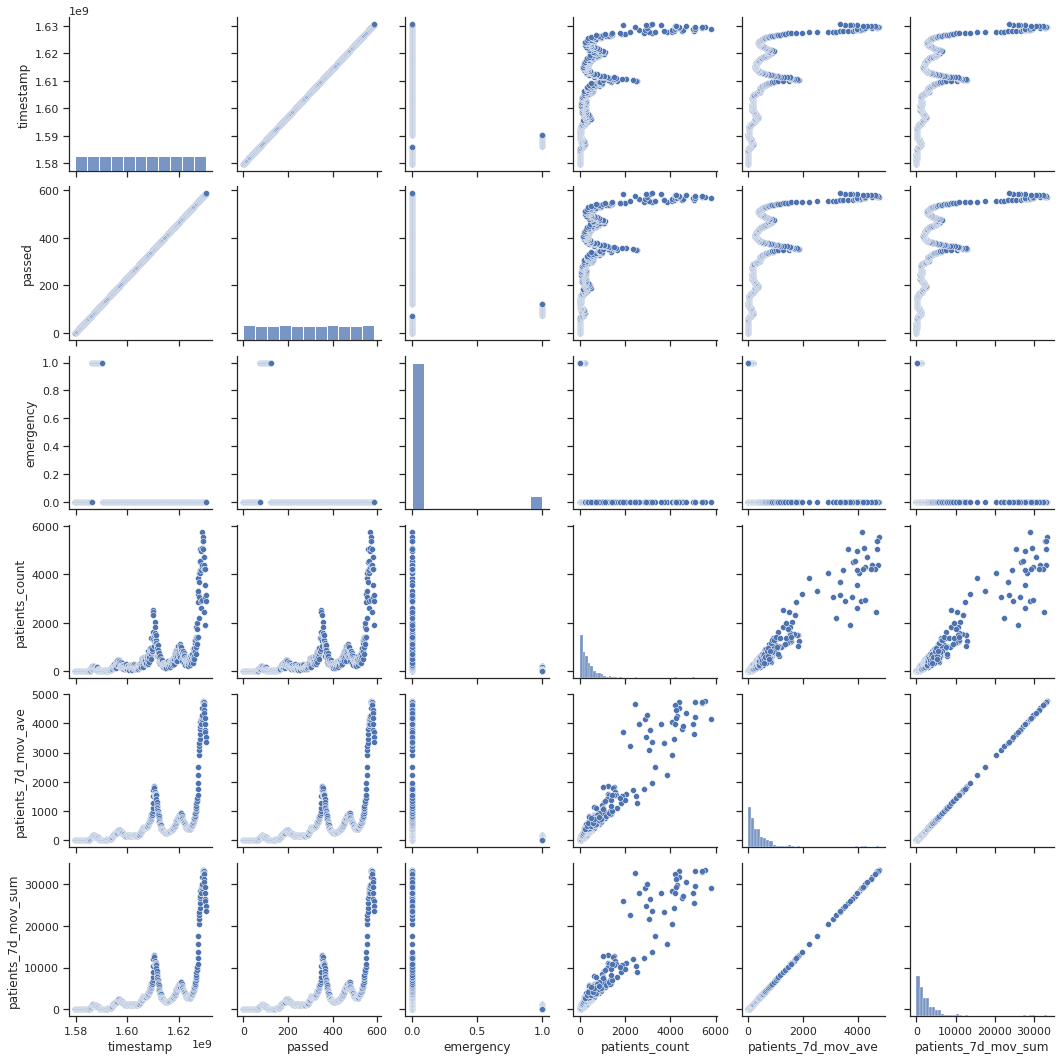

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.11
